In [1]:
from pathlib import Path
import pydicom
import matplotlib.pyplot as plt
import numpy as np

import SimpleITK as sitk
import os

from skimage.transform import radon, iradon

In [2]:
# Function that generates QUBO model coefficients for each pixel in the sinogram.
def add_QUBO(position, values, sinogram_values):
    linear = np.square(values)
    tmp1 = values*np.transpose(values)
    tmp2 = np.ones(np.size(position)) - np.eye(np.size(position))
    tmp3 = linear - 2*sinogram_values*values
    return np.triu(2*np.multiply(tmp1,tmp2) + np.diag(tmp3.flatten()))

# Function that converts a QUBO formultion into a form that can be input into the D-Wave QPU solver.
def Q_mat(qubits,QM):
    max_d = format(len(str(qubits)), '02')
    
    # linear terms
    Q = {}
    for i in range(qubits):
        linear_term = format(i + 1, max_d)
        exec("Q.update({('q%s','q%s'):%s})"%(linear_term, linear_term, format(QM[i][i])))
    
    # quadratic terms
    for i in range(qubits-1):
        for j in range(i+1,qubits):
            if QM[i][j] != 0:
                qdrt1 = format(i + 1, max_d)
                qdrt2 = format(j + 1, max_d)
                exec("Q.update({('q%s','q%s'):%s})"%(qdrt1,qdrt2,format(QM[i][j])))
    return Q

# Function to randomly remove projection images from the sinogram
def add_vertical_artifact(sinogram, num_streaks=3):
    # sinogram = np.transpose(sinogram)
    artifact_sinogram = sinogram.copy()
    cols = sinogram.shape[1]
    rows = sinogram.shape[0]
    artifact = np.zeros((rows,cols))
    wh_cols = np.random.choice(range(0, cols), num_streaks, replace=False)

    
    for _ in range(num_streaks):
        artifact_sinogram[:,wh_cols[_]] = 0*artifact_sinogram[:,wh_cols[_]]
        artifact[:,wh_cols[_]] += 1
    
    return artifact_sinogram, artifact, wh_cols


ID_0000_AGE_0060_CONTRAST_1_CT.dcm


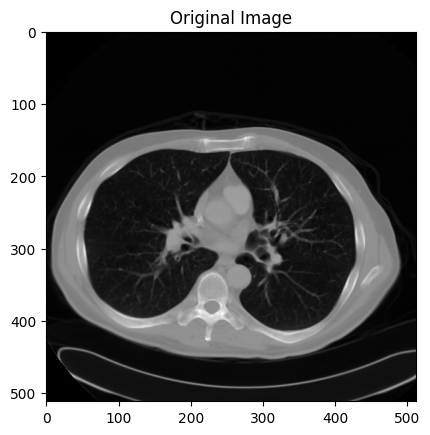

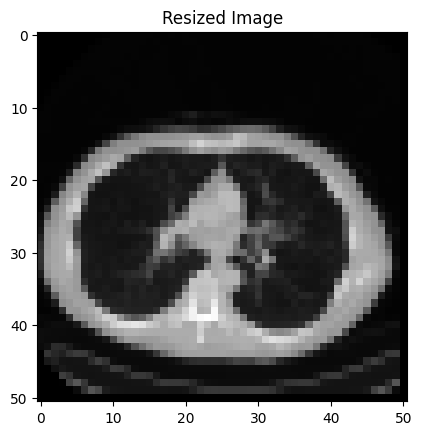

In [3]:
# Experimental dataset obtained from Kaggle
img_idx = 83

path_to_head_mri = Path('C:/Users/USER/archive/dicom_dir')
series_ids = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(path_to_head_mri))
series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(path_to_head_mri),series_ids[img_idx])
dicom_file = pydicom.dcmread('C:/Users/USER/archive/dicom_dir/'+os.path.split(series_file_names[0])[1])
img1  = dicom_file.pixel_array

plt.figure()
plt.title('Original Image')
plt.imshow(img1,cmap="grey")
print(os.path.split(series_file_names[0])[1])

# binning
IS = img1
ori_size = np.shape(IS)
bin_num = 10
new_size = int(ori_size[0]/bin_num)
resized_IS = np.zeros((new_size,new_size))


for j in range(0,50):      
    for i in range(0,50):      
        resized_IS[i,j] = np.average(IS[i*bin_num:(i+1)*bin_num,j*bin_num:(j+1)*bin_num])

plt.figure()
plt.title('Resized Image')
plt.imshow(resized_IS,cmap="gray")

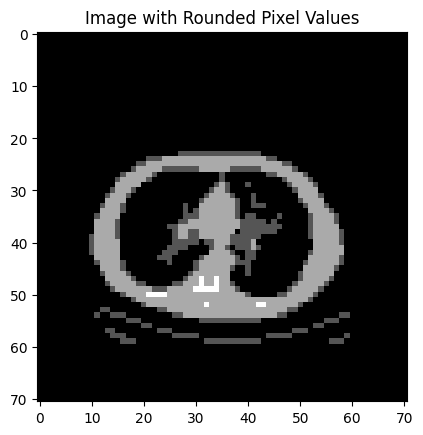

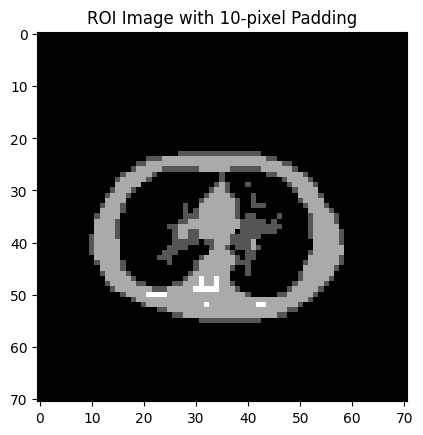

In [4]:
# projection angles for the sinogram.
num_qb = 3
nx = 50
pad = 10

dtheta = 180/nx
theta = np.arange(0, 180, dtheta)

# Padding the resized_IS image by 10 pixels on all sides
# This ensures the image is expanded uniformly with a border of 10 pixels
phantom = np.pad(resized_IS, ((pad,pad),(pad,pad)))

dtheta = 180/nx
max_angle = 180
tnp = max_angle/dtheta
theta = np.arange(0, 180, dtheta)

# Round each pixel value to the nearest integer within the range of 0 to num_qb
rs_phantom = phantom/np.max(phantom)*(num_qb)
fn_phantom = np.round(rs_phantom, 0)

plt.figure()
plt.title("Image with Rounded Pixel Values")
plt.imshow(fn_phantom,cmap="gray")
# plt.colorbar()
plt.show()

# Remove the areas of the image that do not contain any objects
fn2 = fn_phantom.copy()
fn2[56:,:] = 0
fn2[53:,10:20] = 0
fn2[54:,55:] = 0

plt.figure()
plt.title("ROI Image with 10-pixel Padding")
plt.imshow(fn2,cmap="gray")
plt.show()

sino = radon(fn2, theta)



### Body CT image of size 50 x 50, 10 pad, pixel values: 0~3, zero projection images 10%  

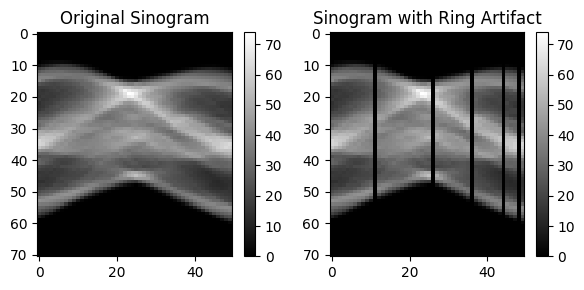

Columns to be set to zero for compatibility with our algorithm :  [11 26 36 44 48]
Count of rows containing zero projection images :  5


In [ ]:
# Function to randomly select projection angles in the sinogram  
# and remove the corresponding projection images  
num_ratio = 0.1
artifact_sinogram, artifacts, wh_artifacts = add_vertical_artifact(sino, num_rings=round(len(theta)*num_ratio))

# Visualizing the sinogram and zero projection images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original Sinogram")
plt.imshow(sino, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Sinogram with Ring Artifact")
plt.imshow(artifact_sinogram, cmap='gray', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()

# Columns to be set to zero for compatibility with our algorithm
zero_cols = np.transpose(sorted(wh_artifacts))
print("Columns to be set to zero for compatibility with our algorithm : ", zero_cols)
print("Count of rows containing zero projection images : ", len(zero_cols))

In [6]:
QM = np.zeros((num_qb*nx**2,num_qb*nx**2))
 
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(tnp)):
    if np.isin(sino_ny, zero_cols):
        pass
    else:
        temp_theta = [theta[sino_ny]]
        for sino_nx in range(0,nx+2*pad):
            Arr_pos = np.array([])
            Arr_val = np.array([])
            for j in range(0,nx):
                for i in range(0,nx):
                    G = np.zeros((nx+2*pad,nx+2*pad))
                    G[i+pad][j+pad] = 1
                    R = radon(G, temp_theta)
                    for qb in range(0, num_qb):
                        Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                        Arr_val = np.append(Arr_val, np.array(R[sino_nx+pad][0]))
            sino_val = artifact_sinogram[sino_nx][sino_ny]
            QM = QM + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
            Fin_Min -= sino_val**2

In [7]:
# Transform the QM matrix into a dictionary format for D-Wave input
Q = Q_mat(num_qb*nx*nx, QM)

# Use D-Wave's Leap Hybrid Sampler to solve the QUBO problem
# The sampler runs a hybrid quantum-classical algorithm to find an optimal solution
# 'answer' contains the sampled results from the quantum annealer
from dwave.system import LeapHybridSampler

sampler = LeapHybridSampler()
answer = sampler.sample_qubo(Q)

print(answer,'\n')

print('Target minimum energy = ', Fin_Min)
print("Our minimum energy = ", answer.record[0][1])

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q7500          energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -2259389.476079       1
[BINARY, 1 rows, 1 samples, 7500 variables]

Target minimum energy =  -2259389.4760791254
Our minimum energy =  -2259389.4760791473


MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image
MAE for QA =  0.0
MAE for FFT =  0.16133008966417042
MAE for FFT (integer) =  0.0432
MAE for FFT without zero cols =  0.1359644520294135
MAE for FFT without zero cols (integer) =  0.018


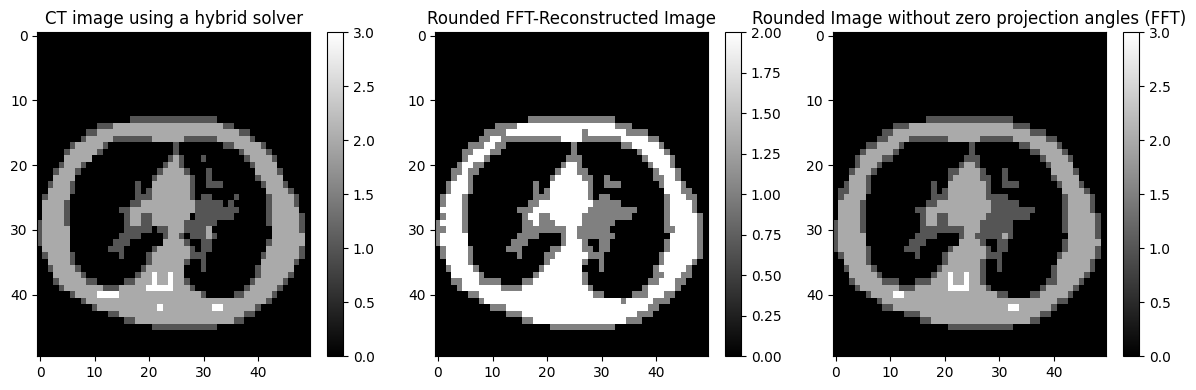

In [ ]:
# Reconstructed image using the proposed method and hybrid solver 
data = answer.record[0][0] 

CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*(num_qb) + j*(num_qb)*nx + k]

original_img = fn2[pad:nx+pad,pad:nx+pad]

# Reconstructed image using FFT
recon_img = iradon(artifact_sinogram,theta)
# Reconstructed image using FFT, converted to integer values using rounding
integer_recon_image = np.round(recon_img).astype(int)
# Reconstructed image using FFT without zero projection angels
new_theta = np.delete(theta, zero_cols)
new_sino = np.delete(sino, zero_cols, axis=1)
new_fft = iradon(new_sino,new_theta)
# Rounded image of the FFT-reconstructed image without zero projection angles
new_integer_fft = np.round(new_fft).astype(int)

print("MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image")
print("MAE for QA = ", np.mean(np.abs(original_img - CT_phantom)))
print("MAE for FFT = ",np.mean(np.abs(original_img - recon_img[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT (integer) = ",np.mean(np.abs(original_img - integer_recon_image[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT without zero cols = ", np.mean(np.abs((fn2-new_fft)[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT without zero cols (integer) = ", np.mean(np.abs((fn2-new_integer_fft)[pad:nx+pad,pad:nx+pad])))

# Comparison of Reconstruction Results
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title("CT image using a hybrid solver")
plt.imshow(CT_phantom, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Rounded FFT-Reconstructed Image")
plt.imshow(integer_recon_image[pad:nx+pad,pad:nx+pad], cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Rounded Image without zero projection angles (FFT)")
plt.imshow(new_integer_fft[pad:nx+pad,pad:nx+pad], cmap='gray', aspect='auto',vmin=0,vmax=num_qb)
plt.colorbar()

plt.tight_layout()
plt.show()


### Body CT image of size 50 x 50, 10 pad, pixel values: 0~3, zero projection images 30%  

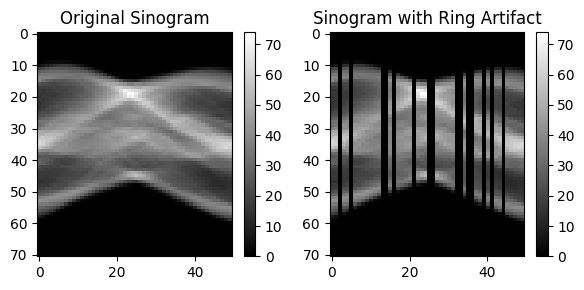

Rows to be set to zero for compatibility with our algorithm :  [ 2  5 13 14 16 21 25 26 32 33 35 36 39 41 44]
Count of rows containing zero projection images :  15


In [ ]:
# Function to randomly select projection angles in the sinogram  
# and remove the corresponding projection images  
num_ratio = 0.3
artifact_sinogram, artifacts, wh_artifacts = add_vertical_artifact(sino, num_rings=round(len(theta)*num_ratio))

# Visualizing the sinogram and zero projection images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original Sinogram")
plt.imshow(sino, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Sinogram with Ring Artifact")
plt.imshow(artifact_sinogram, cmap='gray', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()

# Columns to be set to zero for compatibility with our algorithm
zero_cols = np.transpose(sorted(wh_artifacts))
print("Rows to be set to zero for compatibility with our algorithm : ", zero_cols)
print("Count of rows containing zero projection images : ", len(zero_cols))

In [10]:
QM = np.zeros((num_qb*nx**2,num_qb*nx**2))
 
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(tnp)):
    if np.isin(sino_ny, zero_cols):
        pass
    else:
        temp_theta = [theta[sino_ny]]
        for sino_nx in range(0,nx+2*pad):
            Arr_pos = np.array([])
            Arr_val = np.array([])
            for j in range(0,nx):
                for i in range(0,nx):
                    G = np.zeros((nx+2*pad,nx+2*pad))
                    G[i+pad][j+pad] = 1
                    R = radon(G, temp_theta)
                    for qb in range(0, num_qb):
                        Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                        Arr_val = np.append(Arr_val, np.array(R[sino_nx+pad][0]))
            sino_val = artifact_sinogram[sino_nx][sino_ny]
            QM = QM + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
            Fin_Min -= sino_val**2

In [11]:
# Transform the QM matrix into a dictionary format for D-Wave input
Q = Q_mat(num_qb*nx*nx, QM)

# Use D-Wave's Leap Hybrid Sampler to solve the QUBO problem
# The sampler runs a hybrid quantum-classical algorithm to find an optimal solution
# 'answer' contains the sampled results from the quantum annealer
from dwave.system import LeapHybridSampler

sampler = LeapHybridSampler()
answer = sampler.sample_qubo(Q)

print(answer,'\n')

print('Target minimum energy = ', Fin_Min)
print("Our minimum energy = ", answer.record[0][1])

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q7500          energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -1750436.851206       1
[BINARY, 1 rows, 1 samples, 7500 variables]

Target minimum energy =  -1750436.8512061152
Our minimum energy =  -1750436.8512061695


MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image
MAE for QA =  0.0
MAE for FFT =  0.27443444930085453
MAE for FFT (integer) =  0.2016
MAE for FFT without zero cols =  0.2041148283843415
MAE for FFT without zero cols (integer) =  0.0684


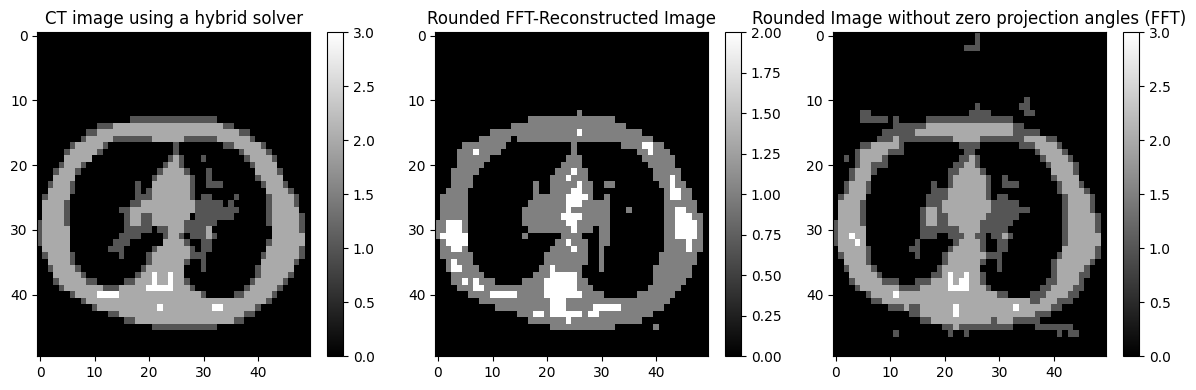

In [ ]:
# Reconstructed image using the proposed method and hybrid solver 
data = answer.record[0][0]  

CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*(num_qb) + j*(num_qb)*nx + k]

original_img = fn2[pad:nx+pad,pad:nx+pad]

# Reconstructed image using FFT
recon_img = iradon(artifact_sinogram,theta)
# Reconstructed image using FFT, converted to integer values using rounding
integer_recon_image = np.round(recon_img).astype(int)
# Reconstructed image using FFT without zero projection angels
new_theta = np.delete(theta, zero_cols)
new_sino = np.delete(sino, zero_cols, axis=1)
new_fft = iradon(new_sino,new_theta)
# Rounded image of the FFT-reconstructed image without zero projection angles
new_integer_fft = np.round(new_fft).astype(int)

print("MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image")
print("MAE for QA = ", np.mean(np.abs(original_img - CT_phantom)))
print("MAE for FFT = ",np.mean(np.abs(original_img - recon_img[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT (integer) = ",np.mean(np.abs(original_img - integer_recon_image[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT without zero cols = ", np.mean(np.abs((fn2-new_fft)[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT without zero cols (integer) = ", np.mean(np.abs((fn2-new_integer_fft)[pad:nx+pad,pad:nx+pad])))

# Comparison of Reconstruction Results
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title("CT image using a hybrid solver")
plt.imshow(CT_phantom, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Rounded FFT-Reconstructed Image")
plt.imshow(integer_recon_image[pad:nx+pad,pad:nx+pad], cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Rounded Image without zero projection angles (FFT)")
plt.imshow(new_integer_fft[pad:nx+pad,pad:nx+pad], cmap='gray', aspect='auto',vmin=0,vmax=num_qb)
plt.colorbar()

plt.tight_layout()
plt.show()


### Body CT image of size 50 x 50, 10 pad, pixel values: 0~3, zero projection images 50%  

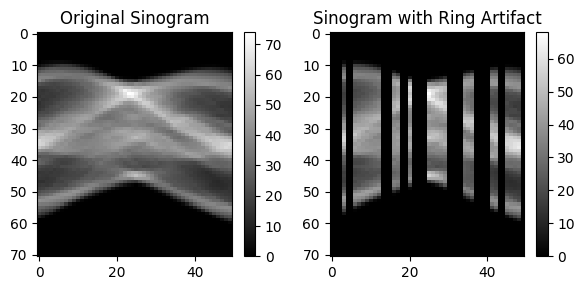

Rows to be set to zero for compatibility with our algorithm :  [ 0  1  2  4  5 13 14 15 18 19 21 22 23 24 30 31 32 33 37 38 39 40 43 44
 49]
Count of rows containing zero projection images :  25


In [ ]:
# Function to randomly select projection angles in the sinogram  
# and remove the corresponding projection images  
num_ratio = 0.5
artifact_sinogram, artifacts, wh_artifacts = add_vertical_artifact(sino, num_rings=round(len(theta)*num_ratio))

# Visualizing the sinogram and zero projection images
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original Sinogram")
plt.imshow(sino, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Sinogram with Ring Artifact")
plt.imshow(artifact_sinogram, cmap='gray', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()

# Columns to be set to zero for compatibility with our algorithm
zero_cols = np.transpose(sorted(wh_artifacts))
print("Rows to be set to zero for compatibility with our algorithm : ", zero_cols)
print("Count of rows containing zero projection images : ", len(zero_cols))

In [14]:
QM = np.zeros((num_qb*nx**2,num_qb*nx**2))
 
Fin_Min = 0
num_row = num_qb*nx
for sino_ny in range(0,int(tnp)):
    if np.isin(sino_ny, zero_cols):
        pass
    else:
        temp_theta = [theta[sino_ny]]
        for sino_nx in range(0,nx+2*pad):
            Arr_pos = np.array([])
            Arr_val = np.array([])
            for j in range(0,nx):
                for i in range(0,nx):
                    G = np.zeros((nx+2*pad,nx+2*pad))
                    G[i+pad][j+pad] = 1
                    R = radon(G, temp_theta)
                    for qb in range(0, num_qb):
                        Arr_pos = np.append(Arr_pos, np.array(i+num_row*(j)))
                        Arr_val = np.append(Arr_val, np.array(R[sino_nx+pad][0]))
            sino_val = artifact_sinogram[sino_nx][sino_ny]
            QM = QM + add_QUBO(Arr_pos.reshape(-1,1), Arr_val.reshape(-1,1), sino_val)
            Fin_Min -= sino_val**2

In [15]:
# Transform the QM matrix into a dictionary format for D-Wave input
Q = Q_mat(num_qb*nx*nx, QM)

# Use D-Wave's Leap Hybrid Sampler to solve the QUBO problem
# The sampler runs a hybrid quantum-classical algorithm to find an optimal solution
# 'answer' contains the sampled results from the quantum annealer
from dwave.system import LeapHybridSampler

sampler = LeapHybridSampler()
answer = sampler.sample_qubo(Q)

print(answer,'\n')

print('Target minimum energy = ', Fin_Min)
print("Our minimum energy = ", answer.record[0][1])

  q0001 q0002 q0003 q0004 q0005 q0006 q0007 ... q7500          energy num_oc.
0     0     0     0     0     0     0     0 ...     0 -1244580.345911       1
[BINARY, 1 rows, 1 samples, 7500 variables]

Target minimum energy =  -1244580.3459114134
Our minimum energy =  -1244580.3459113883


MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image
MAE for QA =  0.0
MAE for FFT =  0.40792149858147925
MAE for FFT (integer) =  0.3044
MAE for FFT without zero cols =  0.3408190438421111
MAE for FFT without zero cols (integer) =  0.2368


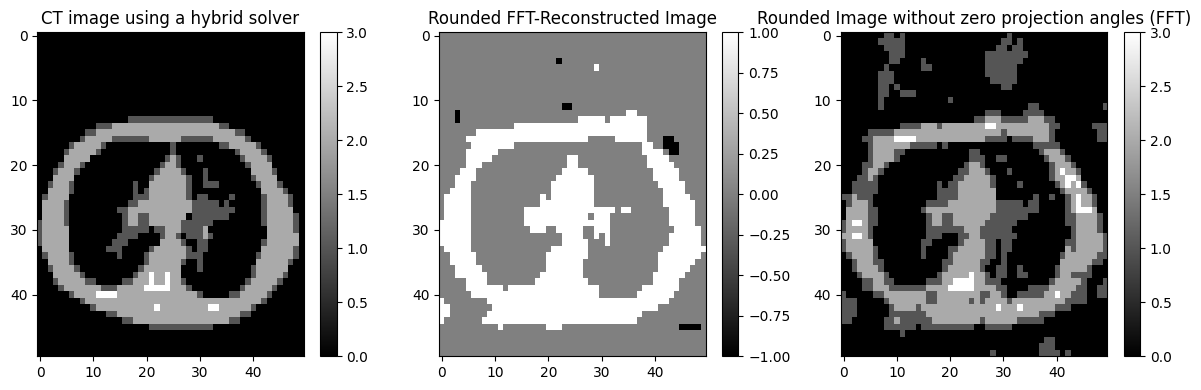

In [16]:
# Reconstructed image using the proposed method and hybrid solver 
data = answer.record[0][0]  

CT_phantom = np.zeros((nx,nx))
for j in range(0,nx):
    for i in range(0,nx):
        for k in range(0,num_qb):
            CT_phantom[i][j] = CT_phantom[i][j] + data[i*(num_qb) + j*(num_qb)*nx + k]

original_img = fn2[pad:nx+pad,pad:nx+pad]

# Reconstructed image using FFT
recon_img = iradon(artifact_sinogram,theta)
# Reconstructed image using FFT, converted to integer values using rounding
integer_recon_image = np.round(recon_img).astype(int)
# Reconstructed image using FFT without zero projection angels
new_theta = np.delete(theta, zero_cols)
new_sino = np.delete(sino, zero_cols, axis=1)
new_fft = iradon(new_sino,new_theta)
# Rounded image of the FFT-reconstructed image without zero projection angles
new_integer_fft = np.round(new_fft).astype(int)

print("MAE Comparison: Our Method vs. Original Image & FFT Result vs. Original Image")
print("MAE for QA = ", np.mean(np.abs(original_img - CT_phantom)))
print("MAE for FFT = ",np.mean(np.abs(original_img - recon_img[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT (integer) = ",np.mean(np.abs(original_img - integer_recon_image[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT without zero cols = ", np.mean(np.abs((fn2-new_fft)[pad:nx+pad,pad:nx+pad])))
print("MAE for FFT without zero cols (integer) = ", np.mean(np.abs((fn2-new_integer_fft)[pad:nx+pad,pad:nx+pad])))

# Comparison of Reconstruction Results
plt.figure(figsize=(12, 4))
plt.subplot(1,3,1)
plt.title("CT image using a hybrid solver")
plt.imshow(CT_phantom, cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Rounded FFT-Reconstructed Image")
plt.imshow(integer_recon_image[pad:nx+pad,pad:nx+pad], cmap='gray', aspect='auto')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Rounded Image without zero projection angles (FFT)")
plt.imshow(new_integer_fft[pad:nx+pad,pad:nx+pad], cmap='gray', aspect='auto',vmin=0,vmax=num_qb)
plt.colorbar()

plt.tight_layout()
plt.show()
